# Theoretical Clustering Guarantees 
We want to check the theoretical clustering guarantee conditions make in the "Dimensionality Reduction via Dynamical Systems" paper, first on a small dataset and then on flow. 

We want to visualize the $P$ matrices and look at whether we find clear clusters. 

## Iris dataset 

In [18]:
%matplotlib inline 
from sklearn.datasets import load_iris
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
dataset = load_iris()
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

iris = pd.DataFrame(
    dataset.data,
    columns=features)

iris[target] = dataset.target


In [7]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
iris[features]

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [4]:
import openTSNE

p_ij_30 = openTSNE.affinity.PerplexityBasedNN(
    iris[features].to_numpy(),
    perplexity=30, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds


### running t-sne on iris

In [47]:
from openTSNE import TSNE
iris_embedding = TSNE(learning_rate=1, early_exaggeration=15, n_iter=1000, n_jobs=-1, random_state=42, negative_gradient_method='bh', verbose=True).fit(iris[features])

--------------------------------------------------------------------------------
TSNE(early_exaggeration=15, learning_rate=1, n_iter=1000, n_jobs=-1,
     negative_gradient_method='bh', random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=15.00, lr=1.00 for 250 iterations...
Iteration   50, KL divergence 1.5243, 50 iterations in 0.3567 sec
Iteration  100, KL divergence 1.0011, 50 iterations in 0.2945 sec
Iteration  150, KL divergence 0.9673, 50 iterations in 0.2389 sec
Iteration  200, KL divergence 0.9514, 50 iterations in 0.1751 sec
Iteration  250, KL divergence 0.9512, 50 iterations in 0.3353 sec
   --> Time elapsed: 1.40 s

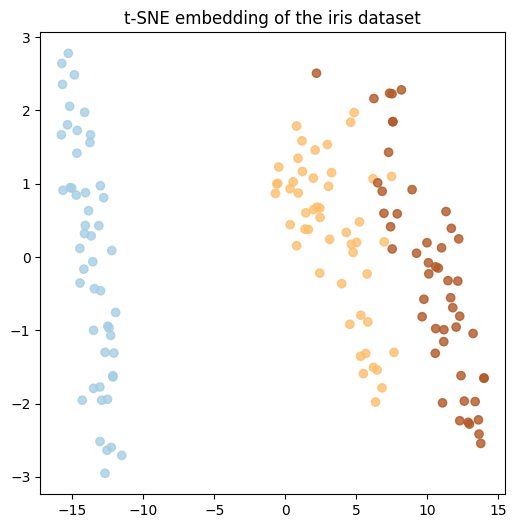

In [53]:
# visualize embedding after early exaggeration 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, title='t-SNE embedding of the iris dataset')
# Create the scatter
ax.scatter(
    x=iris_embedding[:,0], 
    y=iris_embedding[:,1], 
    c=iris[target], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.8)
plt.show()

In [5]:
P = p_ij_30.P.toarray()  # Convert sparse matrix to dense format

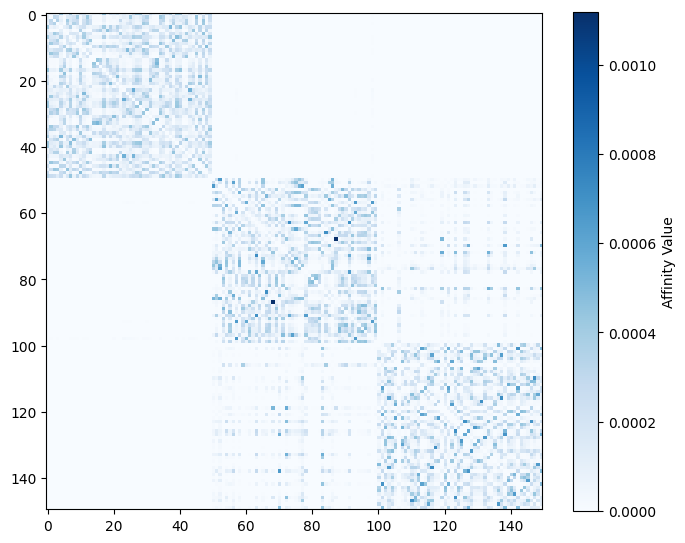

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(P, cmap="Blues", interpolation="nearest")

# Add colorbar only extending to the plot area
cbar = fig.colorbar(cax, ax=ax, label="Affinity Value", shrink=0.81, aspect=20)

#ax.set_title("Affinity Matrix P for iris dataset, perp=30")

plt.show()

In [10]:
len(iris[features])

150

In [11]:
# in the Iris dataset, the values are automatically organized by cluster label, the first 50 ones corresponding to label 1 and so on
# we now want to check the assumption made in the paper 
n = len(iris[features])
cluster_size = 50 
min_pij = 1 / (10 * n * cluster_size)

In [16]:
# check assumption
P_first_cluster = P[:cluster_size, :cluster_size]
P_first_cluster.shape

(50, 50)

In [30]:
def check_cluster(P_cluster, min_value):
    # Get indices of off-diagonal elements
    rows, cols = np.triu_indices_from(P_cluster, k=1)  # Upper triangle (excluding diagonal)
    lower_rows, lower_cols = np.tril_indices_from(P_cluster, k=-1)  # Lower triangle (excluding diagonal)

    # Extract off-diagonal values
    upper_values = P_cluster[rows, cols]
    lower_values = P_cluster[lower_rows, lower_cols]

    # Filter values smaller than min_pij
    filtered_values = np.concatenate((upper_values[upper_values < min_value], 
                                    lower_values[lower_values < min_value]))

    # Print results
    print(f"Total count of p_ij smaller than min value: {filtered_values.size}")
    if filtered_values.size > 0:
        print(f"Smallest value: {filtered_values.min()}")
    else:
        print("No values below threshold.")

In [50]:
min_pij

1.3333333333333333e-05

In [49]:
check_cluster(P[:50, :50], min_pij)

Total count of p_ij smaller than min value: 354
Smallest value: 2.1877105024160235e-07


In [31]:
check_cluster(P[50:100, 50:100], min_pij)

Total count of p_ij smaller than min value: 706
Smallest value: 0.0


In [32]:
check_cluster(P[100:150, 100:150], min_pij)

Total count of p_ij smaller than min value: 662
Smallest value: 9.773568223396807e-11


In [54]:
check_cluster(P[50:, 50:], min_pij*2)

Total count of p_ij smaller than min value: 6210
Smallest value: 0.0


## mnist dataset

is tooo large

## flow dataset

In [23]:
import flowkit as fk 

# Pre-processing data 
sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

In [24]:
features_flow = df_filtered.drop(columns=['class'])  # All columns except 'class'
labels_flow = df_filtered['class']  # Only the 'class' column

In [25]:
p_ij_flow_50 = openTSNE.affinity.PerplexityBasedNN(
    features_flow.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
)

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 887.45 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 386.12 seconds


In [ ]:
P_flow = p_ij_flow_50.P.toarray()  # Convert sparse matrix to dense format

In [1]:
plt.figure(figsize=(8, 8))
plt.imshow(p_ij_flow_50, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Affinity Value")
plt.title("Affinity Matrix P for flow dataset, perp=50")
plt.show()

NameError: name 'plt' is not defined